In [2]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
print(cwd)

a = tf.truncated_normal([16,128,128,3])
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.shape(a))

b=tf.reshape(a,[16,128*128*3])
sess.run(tf.shape(b))
print(a)


C:\Users\radha\Desktop\TflowIMG
Tensor("truncated_normal_1:0", shape=(16, 128, 128, 3), dtype=float32)


In [37]:
import os
os.system("python C:\\users\\radha\\desktop\\TflowIMG\\dataset.py")
print("loaded py file")
import dataset
print('ld Dataset')
#classes = ['dogs', 'cats']
#num_classes = len(classes)
#import dataset
import tensorflow as tf
import time
from datetime import timedelta
import math
import random
import numpy as np
import os

#Adding Seed so that random initialization is consistent
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)


batch_size = 32

#Prepare input data
classes1 = os.listdir('C:\\users\\radha\\desktop\\Tfdata\\TfTrain')
classes = ['dogs', 'cats']
num_classes = len(classes)
print(num_classes)
print(classes)

# 20% of the data will automatically be used for validation
validation_size = 0.2
img_size = 128
num_channels = 3
train_path='C:\\users\\radha\\desktop\\Tfdata\\TfTrain'

# We shall load all the training and validation images and labels into memory using openCV and use that during training
data = dataset.read_train_sets(train_path, img_size, classes1, validation_size=validation_size)
print(data)

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(len(data.train.labels)))
print("Number of files in Validation-set:\t{}".format(len(data.valid.labels)))



#
tf.summary.FileWriterCache.clear()
session = tf.Session()

# tf.summary.FileWriter('board_beginner',sess.graph)   # magic board  

logdir = 'C:\\users\\radha\\desktop\\Tfdata\\logd\\'
writer = tf.summary.FileWriter(logdir)  # create writer
writer.add_graph(session.graph)

x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

##Network graph params
filter_size_conv1 = 3 
num_filters_conv1 = 32

filter_size_conv2 = 3
num_filters_conv2 = 32

filter_size_conv3 = 3
num_filters_conv3 = 64
    
fc_layer_size = 128

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))



def create_convolutional_layer(input,
               num_input_channels, 
               conv_filter_size,        
               num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)
    
    tf.summary.histogram("weight",weights)
    tf.summary.histogram("Bias",biases )
    tf.summary.histogram("activation",layer)

    return layer

    

def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels] 
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer


def create_fc_layer(input,          
             num_inputs,    
             num_outputs,
             use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    tf.summary.histogram("weight",weights)
    tf.summary.histogram("Bias",biases )
    tf.summary.histogram("activation",layer)
    return layer


layer_conv1 = create_convolutional_layer(input=x,
               num_input_channels=num_channels,
               conv_filter_size=filter_size_conv1,
               num_filters=num_filters_conv1)
layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters_conv1,
               conv_filter_size=filter_size_conv2,
               num_filters=num_filters_conv2)

layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters_conv2,
               conv_filter_size=filter_size_conv3,
               num_filters=num_filters_conv3)
          
layer_flat = create_flatten_layer(layer_conv3)

layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_layer_size,
                     use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_layer_size,
                     num_outputs=num_classes,
                     use_relu=False) 

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, dimension=1)
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session.run(tf.global_variables_initializer()) 

tf.summary.scalar("cross-entropy", cross_entropy)
tf.summary.scalar("accuracy",accuracy)
#tf.summary.image('input',x-image,3)


def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

total_iterations = 0

saverx = tf.train.Saver()
def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)

        
        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(data.train.num_examples/batch_size) == 0: 
            #s=session.run(merged_summary,feed_dict={x: x_batch,   y_true: y_true_batch})
           # write.add_summary(s,i)
                 
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(data.train.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
            saverx.save(session, 'C:\\Users\\radha\\Desktop\\Tfdata\\dogs-cats-model') 


    total_iterations += num_iteration

train(num_iteration=100)



loaded py file
ld Dataset
2
['dogs', 'cats']
Going to read training images
Now going to read TRcat files (Index: 0)
Now going to read TRdog files (Index: 1)
<dataset.read_train_sets.<locals>.DataSets object at 0x0000000032B51F28>
Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		822
Number of files in Validation-set:	205
Training Epoch 1 --- Training Accuracy:  59.4%, Validation Accuracy:  37.5%,  Validation Loss: 0.806
Training Epoch 2 --- Training Accuracy:  68.8%, Validation Accuracy:  56.2%,  Validation Loss: 0.691
Training Epoch 3 --- Training Accuracy:  78.1%, Validation Accuracy:  71.9%,  Validation Loss: 0.684
Training Epoch 4 --- Training Accuracy:  71.9%, Validation Accuracy:  65.6%,  Validation Loss: 0.674


C:\Users\radha\Desktop\TflowIMG
-f d
C:\Users\radha\Desktop\TflowIMG\test2\3.jpg
INFO:tensorflow:Restoring parameters from C:\Users\radha\Desktop\Tfdata\dogs-cats-model
[[0.6068278  0.39317223]]
0.6068278
this image is a DOG
done: Cat 0 :: Dog 1


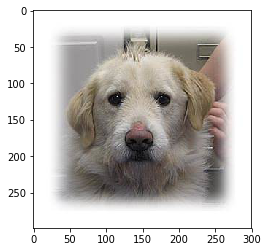

In [36]:
import tensorflow as tf
import numpy as np
import os,glob,cv2
import sys,argparse

train_path='C:\\users\\radha\\desktop\\Tfdata\\TfTrain'
# First, pass the path of the image
dir_path = os.path.dirname(os.path.realpath('__file__'))
print(dir_path)
image_path=sys.argv[1] 
print(image_path, "d")
filename = dir_path +'\\' +"test2\\3.jpg"
print(filename)
image_size=128
num_channels=3
images = []
# Reading the image using OpenCV
image = cv2.imread(filename)
# Resizing the image to our desired size and preprocessing will be done exactly as done during training
image = cv2.resize(image, (image_size, image_size),0,0, cv2.INTER_LINEAR)
images.append(image)
images = np.array(images, dtype=np.uint8)
images = images.astype('float32')
images = np.multiply(images, 1.0/255.0) 
#The input to the network is of shape [None image_size image_size num_channels]. Hence we reshape.
x_batch = images.reshape(1, image_size,image_size,num_channels)

## Let us restore the saved model 
sess = tf.Session()
# Step-1: Recreate the network graph. At this step only graph is created.
saver = tf.train.import_meta_graph('dogs-cats-model.meta')
# Step-2: Now let's load the weights saved using the restore method.
saver.restore(sess, tf.train.latest_checkpoint('./'))

# Accessing the default graph which we have restored
graph = tf.get_default_graph()

# Now, let's get hold of the op that we can be processed to get the output.
# In the original network y_pred is the tensor that is the prediction of the network
y_pred = graph.get_tensor_by_name("y_pred:0")

## Let's feed the images to the input placeholders
x= graph.get_tensor_by_name("x:0") 
y_true = graph.get_tensor_by_name("y_true:0") 
y_test_images = np.zeros((1, len(os.listdir(train_path)))) 


### Creating the feed_dict that is required to be fed to calculate y_pred 
feed_dict_testing = {x: x_batch, y_true: y_test_images}
result=sess.run(y_pred, feed_dict=feed_dict_testing)
# result is of this format [probabiliy_of_rose probability_of_sunflower]
print(result)
print(result[0][0])

if(result[0][0] >=0.60):
    print("this image is a DOG")
else:
    print("this image is a CAT")
print("done: Cat 0 :: Dog 1")

import matplotlib.image as mpimg
img=mpimg.imread(filename)
imgplot = plt.imshow(img)
plt.show()

In [64]:

from graphviz import Digraph

dot = Digraph()

g = tf.Graph()

dot = Digraph(comment='The Round Table')
dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')
dot.edges(['AB', 'AL'])         
dot.edge('B', 'L', constraint='false')   


print(dot.source)  # doctest: +NORMALIZE_WHITESPACE



for n in g.as_graph_def().node:
    # Each node has a name and a label. The name identifies the node
    # while the label is what will be displayed in the graph.
    # We're using the name as a label for simplicity.
    dot.node(n.name, label=n.name)
    
    for i in n.input:
        # Edges are determined by the names of the nodes
        dot.edge(i, n.name)
        print(dot.edge)

import sys
sys.path
"C:\Program Files (x86)\Graphviz2.38\bin\dot"
    

// The Round Table
digraph {
	A [label="King Arthur"]
	B [label="Sir Bedevere the Wise"]
	L [label="Sir Lancelot the Brave"]
	A -> B
	A -> L
	B -> L [constraint=false]
}


'C:\\Program Files (x86)\\Graphviz2.38\x08in\\dot'